Import necessary libraries

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from sklearn.metrics import roc_curve, roc_auc_score

## Dataset Acquisition and Preparation

Download the Dataset:

In [59]:
# Load dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

Data Preparation:

In [60]:
# Split the data into features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


 visualize the distribution of the target classes and some features.

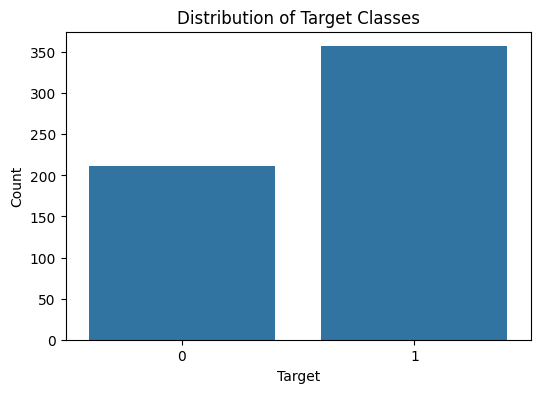

In [71]:
# Visualize the distribution of the target classes
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Classes')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

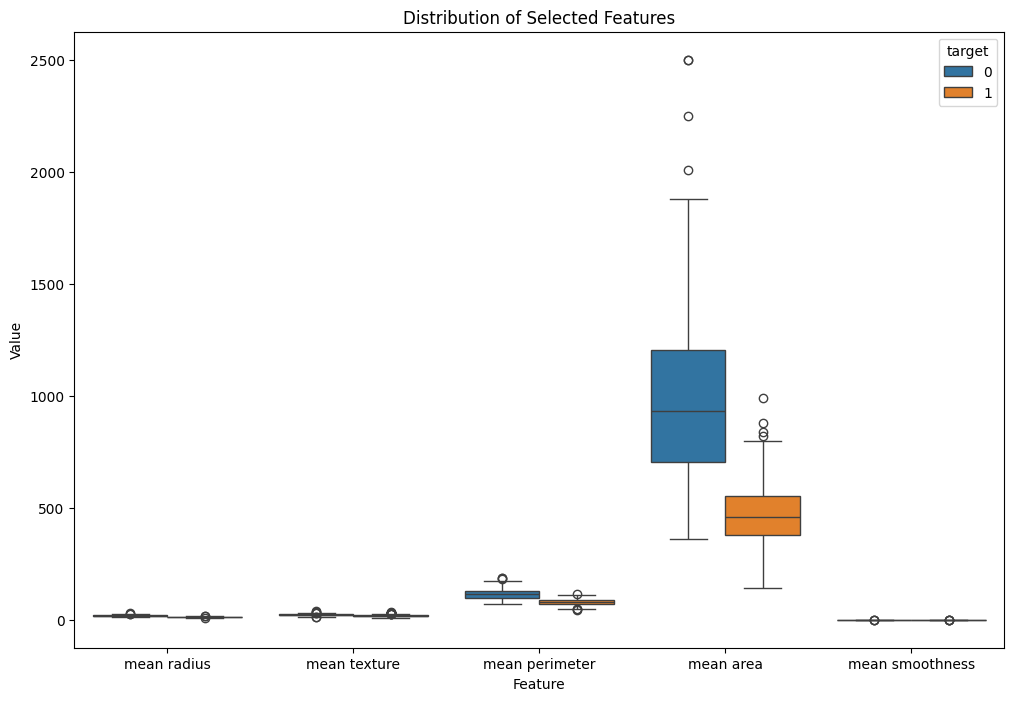

In [73]:
# Visualize the distribution of some features
features_to_plot = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']
df_melt = pd.melt(df, id_vars='target', value_vars=features_to_plot)
plt.figure(figsize=(12, 8))
sns.boxplot(x='variable', y='value', hue='target', data=df_melt)
plt.title('Distribution of Selected Features')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.show()

### Feature Selection

In [61]:
# Feature selection
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

visualize the scores of the features selected by SelectKBest.

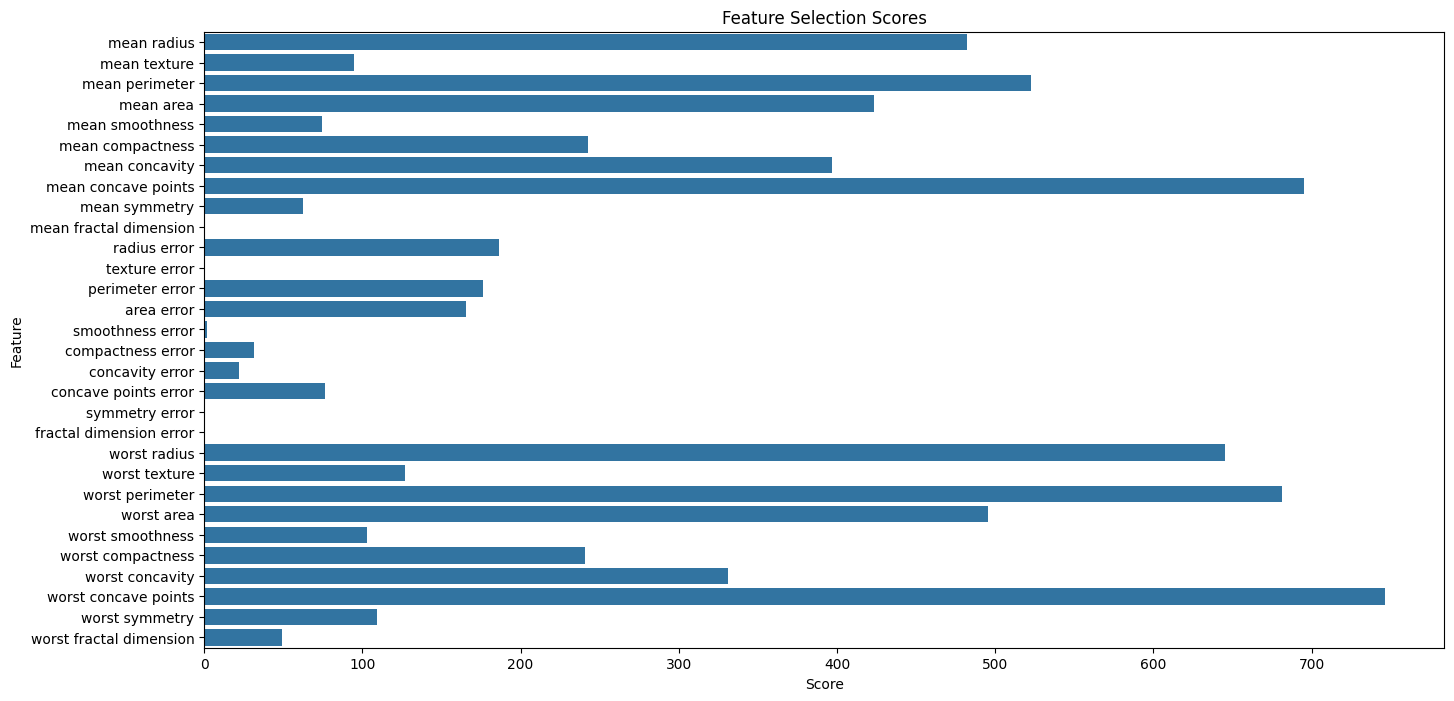

In [77]:
# Plot the scores
plt.figure(figsize=(16, 8))
sns.barplot(x=selector.scores_, y=X.columns)
plt.title('Feature Selection Scores')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()


In [62]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)


### ANN Model Creation and Grid Search CV for Model Tuning

In [63]:
# Define the model
mlp = MLPClassifier(max_iter=100)

# Define the parameter grid
parameter_space = {
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

In [64]:
# Run Grid Search
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train_scaled, y_train)

# Save the best model
joblib.dump(clf.best_estimator_, 'best_model.joblib')

# Print best parameters
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


c:\projects\ANNmodel_BreastCancer\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [79]:
results = pd.DataFrame(clf.cv_results_)

In [81]:
# Load the best model
mlp_model = joblib.load('best_model.joblib')

# Train the model
mlp_model.fit(X_train_scaled, y_train)

c:\projects\ANNmodel_BreastCancer\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.05, hidden_layer_sizes=(50, 50, 50), max_iter=100)

In [66]:
# Evaluate the model
y_pred = mlp_model.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[42  1]
 [ 1 70]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        43
           1       0.99      0.99      0.99        71

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



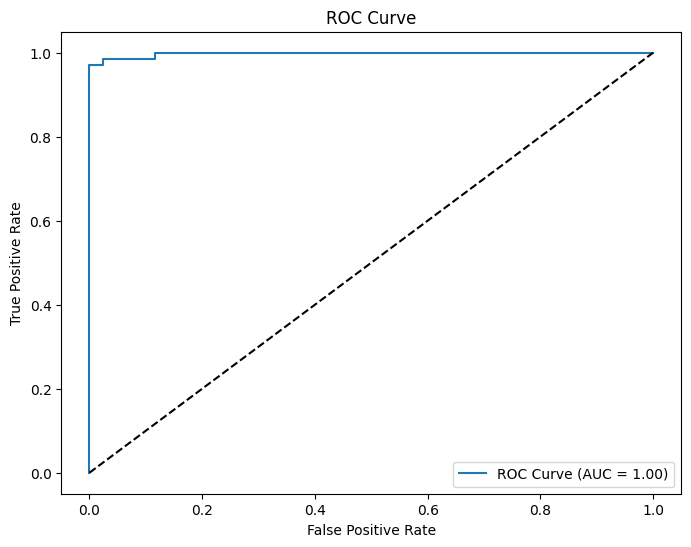

In [83]:
# Visualize ROC Curve

y_prob = mlp_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

In [67]:
# Save the trained model, scaler, and selector
joblib.dump(mlp_model, 'trained_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(selector, 'selector.joblib')

['selector.joblib']